#Install Kaggle

In [2]:
!mkdir ~/.kaggle #create the .kaggle folder in your root directory
!echo '{"username":"koalamuch","key":"5b5a4510cd7128189c928a9e3c90ecc4"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install kaggle #install the kaggle library

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Download dataset

In [3]:
!kaggle competitions download -c hackathon-online-2022-image-processing

 97% 404M/415M [00:09<00:00, 42.3MB/s]
100% 415M/415M [00:09<00:00, 44.0MB/s]


#Unzip dataset

In [4]:
!unzip -o hackathon-online-2022-image-processing.zip

Archive:  hackathon-online-2022-image-processing.zip
  inflating: IM_Submit.csv           
  inflating: IM_Test.zipfile         
  inflating: IM_Train.zipfile        


In [5]:
!unzip -o IM_Test.zipfile
!unzip -o IM_Train.zipfile

Archive:  IM_Test.zipfile
  inflating: IM_Test.zipfile         
Archive:  IM_Train.zipfile
  inflating: IM_Train.zipfile        


In [7]:
!unzip -q -o IM_Train.zipfile
!unzip -q -o IM_Test.zipfile 

In [8]:
import numpy as np
import pandas as pd

(68, 167, 3)


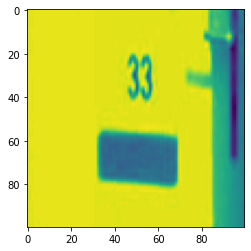

In [15]:
import matplotlib.pyplot as plt
import cv2
width = 100
height = 100
img = cv2.imread('/content/IM_Test/IM_Test/10897.png')
print(img.shape)
resized = cv2.resize(img, (width, height))
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)
plt.show()

#Read Image

In [16]:
def read_img(path,x1=0,y1=0,x2=0,y2=0,box=False):
  image = cv2.imread(path)
  if(box==True):
    image = image[y1:y2, x1:x2, :]
  resized = cv2.resize(image, (height, width))
  gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
  return gray / 255.0

#Prepare train data

In [18]:
import cv2
import matplotlib.pyplot as plt
import os
n_sample = 4200
images = np.zeros((10, n_sample, height, width))
X = np.zeros((10, n_sample, height, width))
y = np.zeros((10, n_sample))
for i in range(10):
  for j, fname in enumerate(os.listdir('/content/train/'+str(i))):
    if(j==4000):
       break
    images[i][j] = read_img('/content/train/'+str(i)+'/'+fname)
for i in range(10):
  last = 0
  for j in range(10):
    if(i==j):
        num_need = n_sample//2
        X[i, last:last+num_need] = images[i][np.random.choice(n_sample, num_need)] 
        y[i, last:last+num_need] = 1
        last = last+num_need
    else:
        num_need = n_sample//18
        X[i, last:last+num_need] = images[j][np.random.choice(n_sample, num_need)]
        y[i, last:last+num_need] = 0
        last = last+num_need

#Create model

In [21]:
import tensorflow as tf
from tensorflow import keras
def create_model():
  model = keras.Sequential()

  # Convolutional layer and maxpool layer 1
  model.add(keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(height, width, 1)))
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 2
  model.add(keras.layers.Conv2D(64,(3,3),activation='relu'))
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 3
  model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
  model.add(keras.layers.MaxPool2D(2,2))

  # Convolutional layer and maxpool layer 4
  model.add(keras.layers.Conv2D(128,(3,3),activation='relu'))
  model.add(keras.layers.MaxPool2D(2,2))

  # This layer flattens the resulting image array to 1D array
  model.add(keras.layers.Flatten())

  # Hidden layer with 512 neurons and Rectified Linear Unit activation function 
  model.add(keras.layers.Dense(512,activation='relu'))

  # Output layer with single neuron which gives 0 for Cat or 1 for Dog 
  #Here we use sigmoid activation function which makes our model output to lie between 0 and 1
  model.add(keras.layers.Dense(1,activation='sigmoid'))
  keras.backend.clear_session()
  return model

#Train model

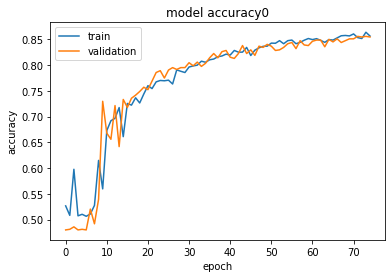

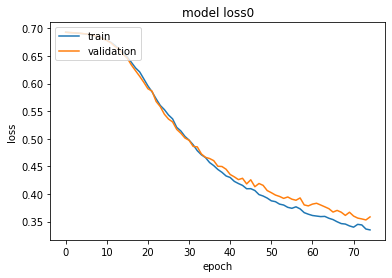

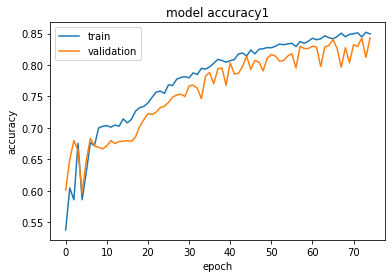

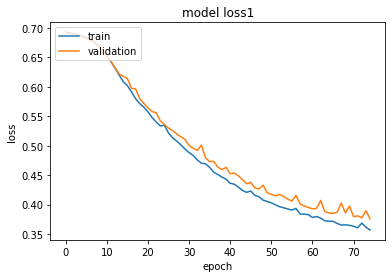

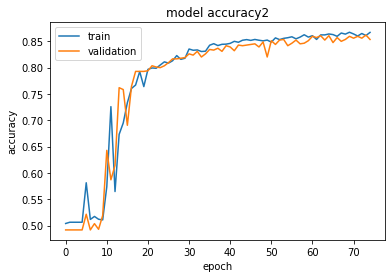

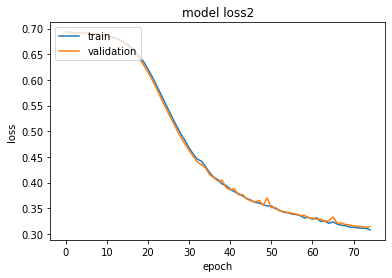

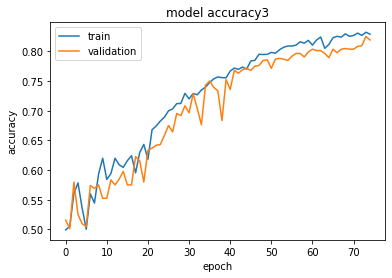

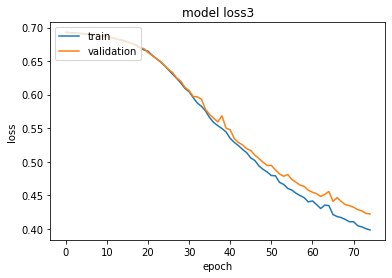

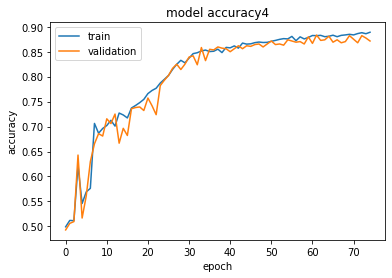

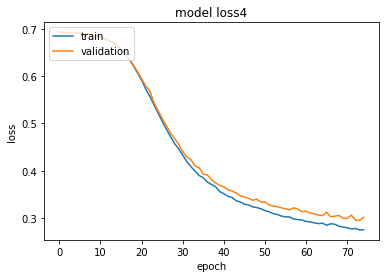

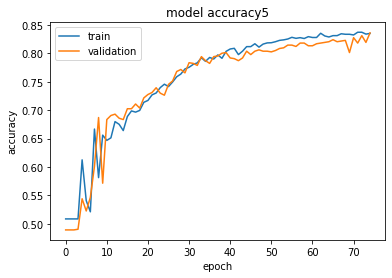

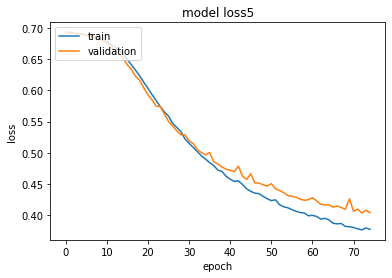

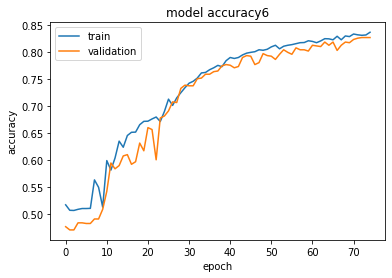

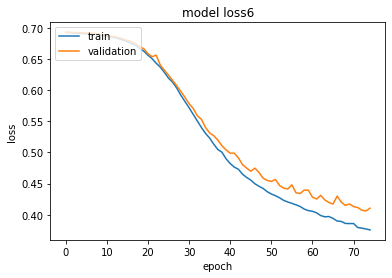

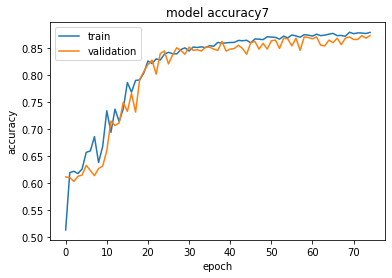

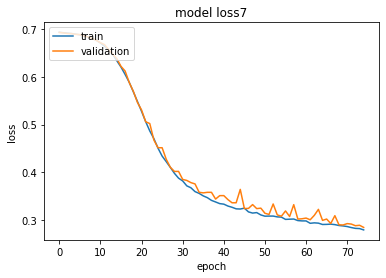

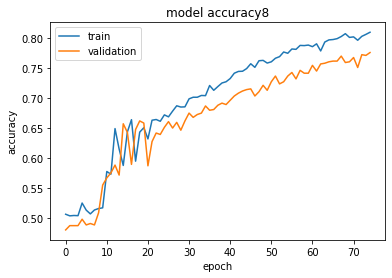

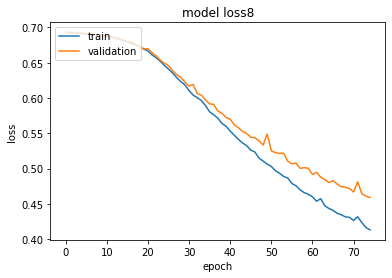

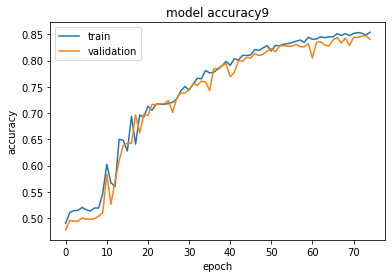

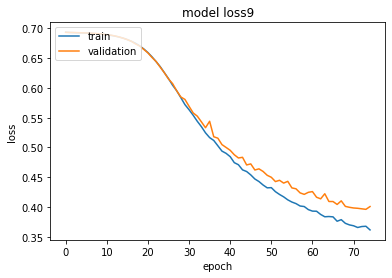

In [24]:
from sklearn.model_selection import train_test_split
models = [[]]*10
for i in range(10):
  X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.2, random_state=42)
  models[i] = create_model()
  opt = keras.optimizers.Adam(learning_rate=0.00001)
  models[i].compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])
  history = models[i].fit(X_train, y_train,
                          batch_size=128,
                          epochs=75,
                          verbose=0,
                          validation_data=(X_test, y_test))
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy'+str(i))
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss'+str(i))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

#Prepare test data

In [25]:
df = pd.read_json('/content/IM_Test/IM_Test.json')
df.head
test_img = np.zeros((26032, height, width))
cnt = 0
for i in range(df.shape[0]):
  path = '/content/IM_Test/IM_Test/'+df['filename'][i]
  for j in df['bboxes'][i]:
    test_img[cnt] = read_img(path, x1=int(j['x1']), y1=int(j['y1']), x2=int(j['x2']), y2=int(j['y2']),box=True)
    cnt = cnt+1

In [26]:
df.head

<bound method NDFrame.head of         filename                                             bboxes
0          1.png  [{'bbox_id': 0, 'x1': 43, 'x2': 62, 'y1': 7, '...
1          2.png  [{'bbox_id': 0, 'x1': 99, 'x2': 113, 'y1': 5, ...
2          3.png  [{'bbox_id': 0, 'x1': 61, 'x2': 72, 'y1': 6, '...
3          4.png  [{'bbox_id': 0, 'x1': 32, 'x2': 46, 'y1': 6, '...
4          5.png  [{'bbox_id': 0, 'x1': 97, 'x2': 116, 'y1': 28,...
...          ...                                                ...
13063  13064.png  [{'bbox_id': 0, 'x1': 227, 'x2': 249, 'y1': 43...
13064  13065.png  [{'bbox_id': 0, 'x1': 67, 'x2': 82, 'y1': 14, ...
13065  13066.png  [{'bbox_id': 0, 'x1': 33, 'x2': 45, 'y1': 19, ...
13066  13067.png  [{'bbox_id': 0, 'x1': 113, 'x2': 126, 'y1': 14...
13067  13068.png  [{'bbox_id': 0, 'x1': 36, 'x2': 47, 'y1': 9, '...

[13068 rows x 2 columns]>

#Predict test data

In [27]:
result = np.zeros((10, 26032))
for i in range(10):
  result[i] = models[i].predict(test_img, verbose=0).flatten()
df = pd.read_csv('IM_Submit.csv')
for i in range(df.shape[0]):
  df.loc[i, 'class'] = np.argmax(result[:, i])
df['class'] = df['class'].fillna(0)
df['class'] = df['class'].astype(int)

#Submit answer

In [28]:
df.to_csv('IM_Submit.csv', index=False)

In [30]:
!kaggle competitions submit -c hackathon-online-2022-image-processing -f IM_Submit.csv -m ""

100% 233k/233k [00:04<00:00, 52.1kB/s]
Successfully submitted to Hackathon Online: Image Processing